In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM,GRU, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.models import model_from_json

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Data Preparation

In [ ]:
!wget "https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio" -P "/tmp/"


--2020-07-07 19:35:26--  https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1785558 (1.7M)
Saving to: ‘/tmp/trivia10k13train.bio’

trivia10k13train.bi 100%[===================>]   1.70M  2.63MB/s    in 0.6s    

2020-07-07 19:35:27 (2.63 MB/s) - ‘/tmp/trivia10k13train.bio’ saved [1785558/1785558]



In [ ]:
!wget "https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio" -P "/tmp/"

--2020-07-07 19:35:30--  https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438729 (428K)
Saving to: ‘/tmp/trivia10k13test.bio’

trivia10k13test.bio 100%[===================>] 428.45K  1.19MB/s    in 0.4s    

2020-07-07 19:35:31 (1.19 MB/s) - ‘/tmp/trivia10k13test.bio’ saved [438729/438729]



In [ ]:
## Read input training data
with open ("/tmp/trivia10k13train.bio", "r") as f:
    lines = [eachLine.rstrip() for eachLine in f]

## Prepare word list, tag list and tuple of sentences
sentences=[]
eachSentence=[]
words=[]
tags=[]
for eachline in lines:
  if eachline != '':
    eachTag,eachWord = eachline.split('\t')
    words.append(eachWord)
    tags.append(eachTag)
    eachSentence.append((eachWord,eachTag))
  else:
    sentences.append(eachSentence)
    eachSentence = []

## Remove duplicates. Add - OOV(out of vocab) ENDPAD to word list
words = list(set(words))
words.append("OOV")
words.append("ENDPAD")
tags = list(set(tags))

num_words = len(words)
num_tags = len(tags)

In [ ]:
## Print number of words and number of tags
num_words, num_tags

(10989, 25)

In [ ]:
## Create word and tag dictionaries
word2idx = {w: i+1 for i,w in enumerate(words)}
tags2idx = {t: i for i,t in enumerate(tags)}

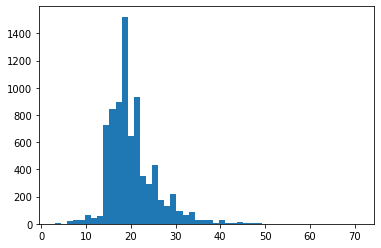

In [ ]:
## Plt the sentence lengths to understand padding requirement
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
## set max length to 45 and generate word sequences with padding. I have chosen post padding.
## Set the padding values to 'ENDPAD' for input and 'O' for tags.

max_len = 45
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len,sequences=X, padding='post', value=num_words-1)

y = [[tags2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tags2idx["O"])


In [ ]:
## Create train and validation split from training set
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

Model Selection

In [ ]:
### Model selection - tried 4 models with different number of layers, number of nodes and types of nodes.
model_lstm_simple = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=64),
                                         tf.keras.layers.Bidirectional(LSTM(units=64,return_sequences=True)),
                                         tf.keras.layers.Dense(64,activation='relu'),
                                         tf.keras.layers.Dense(num_tags, activation='softmax')
                                        ])

model_lstm_medium = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=64),
                                         tf.keras.layers.Bidirectional(LSTM(units=128,return_sequences=True)),
                                         tf.keras.layers.Bidirectional(LSTM(units=32,return_sequences=True)),
                                         tf.keras.layers.Dense(128,activation='relu'),
                                         tf.keras.layers.Dense(num_tags, activation='softmax')
                                        ])

model_lstm_complex = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=64),
                                         tf.keras.layers.Bidirectional(LSTM(units=512,return_sequences=True)),
                                         tf.keras.layers.Bidirectional(LSTM(units=256,return_sequences=True)),
                                         tf.keras.layers.Dense(512,activation='relu'),
                                         tf.keras.layers.Dense(128,activation='relu'),
                                         tf.keras.layers.Dense(num_tags, activation='softmax')
                                        ])

model_gru_simple = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=64),
                                         tf.keras.layers.Bidirectional(GRU(units=64,return_sequences=True)),
                                         tf.keras.layers.Dense(64,activation='relu'),
                                         tf.keras.layers.Dense(num_tags, activation='softmax')
                                        ])

model_gru_medium = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=64),
                                         tf.keras.layers.Bidirectional(GRU(units=128,return_sequences=True)),
                                         tf.keras.layers.Bidirectional(GRU(units=32,return_sequences=True)),
                                         tf.keras.layers.Dense(128,activation='relu'),
                                         tf.keras.layers.Dense(num_tags, activation='softmax')
                                        ])

model_gru_complex = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=64),
                                         tf.keras.layers.Bidirectional(GRU(units=512,return_sequences=True)),
                                         tf.keras.layers.Bidirectional(GRU(units=256,return_sequences=True)),
                                         tf.keras.layers.Dense(512,activation='relu'),
                                         tf.keras.layers.Dense(128,activation='relu'),
                                         tf.keras.layers.Dense(num_tags, activation='softmax')
                                        ])

models_all = [('model_lstm_simple',model_lstm_simple), ('model_lstm_medium',model_lstm_medium),  
              ('model_gru_simple',model_gru_simple), ('model_gru_medium',model_gru_medium) ]

In [ ]:
## Train all the models and save the history for further analysis
## epochs - 30, batch_size = 32
history_all = []
for modelName, model in models_all:
    #print(modelName)
    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    history = model.fit(x=x_train, y=y_train, validation_data=(x_valid,y_valid),
                        batch_size=32,epochs=30,verbose=0)
    history_all.append((modelName,history))

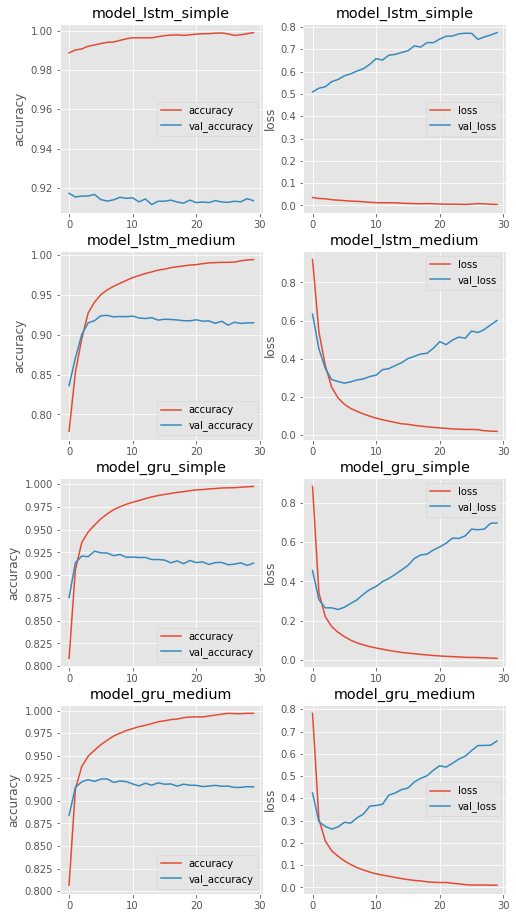

In [ ]:
## Draw accuracy and loss graphs to compare the results

ncols = 2
nrows = 4
i = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for eachHistoryName, eachHistory in history_all:
  i += 1
  sp = plt.subplot(nrows, ncols, i)
  sp.plot(eachHistory.history['accuracy'])
  sp.plot(eachHistory.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.legend(['accuracy', 'val_accuracy'])
  plt.title(eachHistoryName)

  i += 1
  sp = plt.subplot(nrows,ncols,i)
  sp.plot(eachHistory.history['loss'])
  sp.plot(eachHistory.history['val_loss'])
  plt.ylabel('loss')
  plt.legend(['loss', 'val_loss'])
  plt.title(eachHistoryName)


plt.show()

Hyper-Parameter Tuning

In [ ]:
## Function for model defnition with hyperparameters as arguments
def model_defnition(regularization='l2',spatialDropout=0.0,recurrent_dropout=0.0,embed_outdim=64,num_tags=num_tags,num_words=num_words):
    model = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,output_dim=embed_outdim),
                                tf.keras.layers.SpatialDropout1D(spatialDropout),
                                tf.keras.layers.Bidirectional(LSTM(units=64,return_sequences=True,recurrent_dropout=recurrent_dropout)),
                                tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=regularization),
                                tf.keras.layers.Dense(num_tags, activation='softmax')])
    return model
    

In [ ]:
### Prepare a grid of hyperparameters 
spatialDropoutRange = [ 0.1,0.2,0.3,0.4,0.5,0.6]
recurrentDropoutRange = [ 0.1,0.2,0.3,0.4,0.5,0.6]
maxLenRange = [45,60]

hyperParameterGrid = []
for i in spatialDropoutRange:
    for j in recurrentDropoutRange:
        for k in maxLenRange:
                hyperParameterGrid.append((i,j,k))

In [ ]:
## Execute model fit for the range of hyper parameters and save the history for each run
## Also save the each model so that, they can be loaded at a later stage
history_hyper_all = []
for eachSpatialDropout, eachRecurrDropout, eachMaxLen in hyperParameterGrid:
    
    max_len = eachMaxLen
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen=max_len,sequences=X, padding='post', value=num_words-1)

    y = [[tags2idx[w[1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tags2idx["O"])
    
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
    
    
    model = model_defnition(regularization='l2',spatialDropout=eachSpatialDropout,recurrent_dropout=eachRecurrDropout)
    
    early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=True)
    
    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    history = model.fit(x=x_train, y=y_train, validation_data=(x_valid,y_valid),
                        batch_size=32,epochs=30,callbacks=[early_stopping],verbose=0)
    modelName = 'Model_SpatialDropout_'+str(eachSpatialDropout)+'_RecurDropout_'+str(eachRecurrDropout)+'_MaxLen_'+str(eachMaxLen)
    history_hyper_all.append((modelName,history))
    
    ##save model
    model_json = model.to_json()
    with open("/tmp/"+modelName+".json","w") as json_file:
        json_file.write(model_json)
        
    model.save_weights("/tmp/"+modelName+".h5")
    
    #print(modelName)
    #break

Model_SpatialDropout_0.5_RecurDropout_0.3_MaxLen_45


In [ ]:
### Save the history parameters - accuracy, val_accuracy, loss and val_loss into a dataframe and save for further reference.
eval_list = []
for eachHistoryName, eachHistory in history_hyper_all:
    for eachItem in zip(eachHistory.history['accuracy'],eachHistory.history['val_accuracy'],eachHistory.history['loss'],eachHistory.history['val_loss']):
        eval_list.append(eachItem + (eachHistoryName,))

df_history_eval = pd.DataFrame(eval_list)
df_history_eval.to_csv('/tmp/history_eval.csv',index=False) 

In [ ]:
## Verify the metrics - val_accuracy for different iterations
df_history_eval = pd.read_csv('history_eval.csv',encoding='utf-8')
df_history_eval.columns = ['accuracy','val_accuracy','loss','val_loss','iteration']
df_history_eval['epoch'] = df_history_eval.groupby(['iteration']).cumcount()
df_history_eval.groupby(['iteration'])['val_accuracy'].max()

iteration
Model_SpatialDropout_0.1_RecurDropout_0.1_MaxLen_45    0.915402
Model_SpatialDropout_0.1_RecurDropout_0.1_MaxLen_60    0.936861
Model_SpatialDropout_0.1_RecurDropout_0.2_MaxLen_45    0.920503
Model_SpatialDropout_0.1_RecurDropout_0.2_MaxLen_60    0.938033
Model_SpatialDropout_0.1_RecurDropout_0.3_MaxLen_45    0.915857
Model_SpatialDropout_0.1_RecurDropout_0.3_MaxLen_60    0.937138
Model_SpatialDropout_0.2_RecurDropout_0.1_MaxLen_45    0.916411
Model_SpatialDropout_0.2_RecurDropout_0.1_MaxLen_60    0.936871
Model_SpatialDropout_0.2_RecurDropout_0.2_MaxLen_45    0.919565
Model_SpatialDropout_0.2_RecurDropout_0.2_MaxLen_60    0.937830
Model_SpatialDropout_0.2_RecurDropout_0.3_MaxLen_45    0.920304
Model_SpatialDropout_0.2_RecurDropout_0.3_MaxLen_60    0.938949
Model_SpatialDropout_0.3_RecurDropout_0.1_MaxLen_45    0.920332
Model_SpatialDropout_0.3_RecurDropout_0.1_MaxLen_60    0.937884
Model_SpatialDropout_0.3_RecurDropout_0.2_MaxLen_45    0.920389
Model_SpatialDropout_0.3_Recur

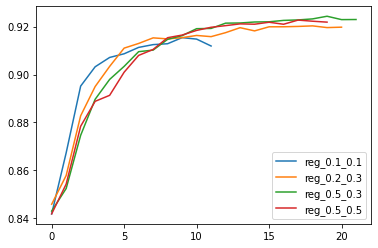

In [ ]:
## Plot and compare models based on val_accuracy
fig, ax = plt.subplots()
intersetedIterations = [('Model_SpatialDropout_0.1_RecurDropout_0.1_MaxLen_45','reg_0.1_0.1'), ('Model_SpatialDropout_0.2_RecurDropout_0.3_MaxLen_45','reg_0.2_0.3'), ('Model_SpatialDropout_0.5_RecurDropout_0.3_MaxLen_45','reg_0.5_0.3'),('Model_SpatialDropout_0.5_RecurDropout_0.5_MaxLen_45','reg_0.5_0.5') ]
#intersetedIterations = [('Model_SpatialDropout_0.2_RecurDropout_0.1_MaxLen_45','reg_0.1_0.1'), ('Model_SpatialDropout_0.4_RecurDropout_0.3_MaxLen_45','reg_0.2_0.3'), ('Model_SpatialDropout_0.5_RecurDropout_0.4_MaxLen_45','reg_0.5_0.3'),('Model_SpatialDropout_0.5_RecurDropout_0.5_MaxLen_45','reg_0.5_0.5') ]
for eachItem,eachLabel in intersetedIterations:
        ax.plot(df_history_eval[df_history_eval['iteration'] == eachItem]['epoch'],df_history_eval[df_history_eval['iteration'] == eachItem]['val_accuracy'],label=eachLabel)
ax.legend()        
plt.show()

Run the model on test dataset and check the performance

In [ ]:
## Load the model chosen
json_file = open('/tmp/Model_SpatialDropout_0.5_RecurDropout_0.3_MaxLen_45.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("/tmp/Model_SpatialDropout_0.5_RecurDropout_0.3_MaxLen_45.h5")

loaded_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
## Read and prepare test data to run predictions
with open ("/tmp/trivia10k13test.bio.txt", "r") as f:
    lines = [eachLine.rstrip() for eachLine in f]

## Prepare word list, tag list and tuple of sentences
testSentences=[]
eachSentence=[]
testWords=[]
testTags=[]
i=0
testSentencesforDF = []
for eachline in lines:
  if eachline != '':
    eachTag,eachWord = eachline.split('\t')
    testWords.append(eachWord)
    testTags.append(eachTag)
    eachSentence.append((eachWord,eachTag))
    testSentencesforDF.append(('sentence'+str(i),eachWord,eachTag))
  else:
    i+=1
    testSentences.append(eachSentence)
    eachSentence = []
  
testWords = list(set(testWords))
testTags = list(set(testTags))

## Apply padding. For new words not seen in train dataset, treat it as OOV
X_test = [[word2idx[w[0]] if w[0] in words else word2idx["OOV"] for w in s] for s in testSentences]
X_test = pad_sequences(maxlen=max_len,sequences=X_test, padding='post', value=num_words-1)

y_test = [[tags2idx[w[1]] for w in s] for s in testSentences]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding='post', value=tags2idx["O"])

In [ ]:
##Evaluate the model
model.evaluate(X_test,y_test)

62/62 [==============================] - 1s 8ms/step - loss: 0.4197 - accuracy: 0.9063


[0.4196816086769104, 0.9063321352005005]

In [ ]:
## Run predictions and then convert the output to actual tags

revtags2idx = {i: w for w, i in tags2idx.items()}

y_test_pred = loaded_model.predict(X_test)
y_test_pred_conv = []
for each_y_test_pred in y_test_pred:
  temp_array = []
  for each_y_test_entry in each_y_test_pred:
    temp_array.append(np.argmax(each_y_test_entry))
  y_test_pred_conv.append(temp_array)

y_test_pred_conv = np.array(y_test_pred_conv)

y_test_labels = [[revtags2idx[w] for w in s] for s in y_test]
y_test_pred_labels = [[revtags2idx[w] for w in s] for s in y_test_pred_conv]

In [ ]:
## Prepare the csv file with predictions and actuals

predvsact=[]
p = loaded_model.predict(np.array(X_test))
for i in range(len(X_test)):
  #print(i)
  eachPred = p[i]
  eachPred = np.argmax(eachPred, axis=-1)
  for w, act, pred in zip(X_test[i], y_test[i], eachPred):
      if w != "PADword":
        predvsact.append(('sentence'+str(i),words[w-1], tags[pred], tags[act]))
  #break

df_predvsact = pd.DataFrame(predvsact,columns=['sentence#','word','predicted','actual'])
df_predvsact['wordcount'] = df_predvsact.groupby(['sentence#']).cumcount()

df_testSentences = pd.DataFrame(testSentencesforDF,columns=['sentence#','word_test','tag'])
df_testSentences['wordcount'] = df_testSentences.groupby(['sentence#']).cumcount()

df_test_predvsact = pd.merge(df_testSentences,df_predvsact,how='inner',on=['sentence#','wordcount'],sort=False)

df_test_predvsact = df_test_predvsact.drop(['tag','wordcount'],axis=1)
df_test_predvsact = df_test_predvsact.rename(columns={'word':'wordconv'})

df_test_predvsact.to_csv('/tmp/testdataset_withpred.csv',index=False)

In [ ]:
df_test_predvsact.head(4)

,sentence#,word_test,wordconv,predicted,actual
0,sentence0,i,i,O,O
1,sentence0,need,need,O,O
2,sentence0,that,that,O,O
3,sentence0,movie,movie,O,O


In [ ]:
## Prepare classification report and save it as a csv
df_classification_report = pd.DataFrame(classification_report(df_test_predvsact['actual'],df_test_predvsact['predicted'],output_dict=True)).transpose()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_classification_report

,precision,recall,f1-score,support
B-Actor,0.874034,0.889151,0.881528,1272.000000
B-Award,0.500000,0.015152,0.029412,66.000000
B-Character_Name,0.447368,0.241135,0.313364,282.000000
B-Director,0.696466,0.788235,0.739514,425.000000
B-Genre,0.718510,0.831432,0.770858,789.000000
B-Opinion,0.000000,0.000000,0.000000,195.000000
B-Origin,0.455172,0.347368,0.394030,190.000000
B-Plot,0.490734,0.419784,0.452495,1577.000000
B-Quote,0.000000,0.000000,0.000000,46.000000
B-Relationship,0.833333,0.176471,0.291262,170.000000


In [ ]:
accuracy_score(df_test_predvsact['actual'],df_test_predvsact['predicted'])

0.788760585065435

Others

In [ ]:
from google.colab import files
uploaded = files.upload()